# VAE

In [1]:
import sys
import os
import seaborn as sns
sys.path.append( '..' )

from VAE.smac_runhistories import *
from VAE.vae import *

## Parameter definition

In [2]:
reports_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/reports/VAE"))
results_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/results"))
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/FIA/Com8_grown_together/oms"))
verbosity = 1

X = read_data(data_dir, verbosity=verbosity)

Data loaded (94.986323595047s)


## Training

In [3]:
# On cluster

In [4]:
backend_name = "tensorflow"
computation = "gpu"
name = "tied_mae_cos_fin"
project = f"vae_{backend_name}_{computation}_{name}"

model_dir = Path(os.path.normpath( os.path.join("/mnt/d/runs/VAE/training", project)))
outdir = os.path.join(reports_dir, project)
if not os.path.isdir(outdir):
    os.mkdir(outdir)

In [5]:
model = keras.saving.load_model(os.path.join(model_dir, f"{project}_best.keras"), custom_objects=None, compile=True, safe_mode=True)

In [6]:
model.summary()

Model: "fia_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_intermediate            │ ?                      │   148,523,710 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_mu (Dense)               │ ?                      │        17,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_sigma (Dense)            │ ?                      │        17,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_reparametrization        │ ?                      │             0 │
│ (Sampling)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ ?                      │   149,348,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,148,853 (1.67 GB)

 Trainable params: 149,382,950 (569.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 298,765,903 (1.11 GB)

## Reconstruction

In [7]:
reconstructed_data = pd.DataFrame( model(X).numpy() )

In [8]:
vae_enc = pd.DataFrame( model.encode_mu(X) )
vae_enc.to_csv( os.path.join(results_dir, f"encoded_mu_{name}.tsv"), sep="\t" )

### Show model

In [9]:
model_plot = keras.utils.plot_model( model, show_shapes=True, show_dtype=False, show_layer_names=True,
                                     rankdir="TB", expand_nested=True, dpi=100, to_file="../../reports/model.png",
                                     show_layer_activations=True, show_trainable=True )

## Plot training

In [10]:
history = pd.read_csv(os.path.join(model_dir, f"{project}.history.tsv"), sep="\t").rename(columns={"Unnamed: 0": "Step",
                                                                                           "loss": "Training Loss", "val_loss": "Validation loss",
                                                                                           "kl_loss": "Training Kullback-Leibler loss", "val_kl_loss": "Validation Kullback-Leibler loss",
                                                                                           "reconstruction_loss": "Training reconstruction loss", "val_reconstruction_loss": "Validation reconstruction loss"})
history

,Step,Training Kullback-Leibler loss,Training Loss,Training reconstruction loss,Validation Kullback-Leibler loss,Validation loss,Validation reconstruction loss
0,0,0.003816,0.986691,0.979266,0.000459,0.979365,0.978270
1,1,0.000726,0.978512,0.976638,0.000059,0.976718,0.976578
2,2,0.000121,0.974620,0.974326,0.000030,0.973833,0.973762
3,3,0.000087,0.971730,0.971531,0.000033,0.971169,0.971091
4,4,0.000108,0.968628,0.968384,0.000025,0.966934,0.966875
...,...,...,...,...,...,...,...
995,995,0.000031,0.056935,0.056860,0.000008,0.052109,0.052089
996,996,0.000029,0.058391,0.058327,0.000012,0.051930,0.051901
997,997,0.000026,0.056775,0.056713,0.000012,0.051933,0.051904
998,998,0.000030,0.057774,0.057703,0.000007,0.052755,0.052738


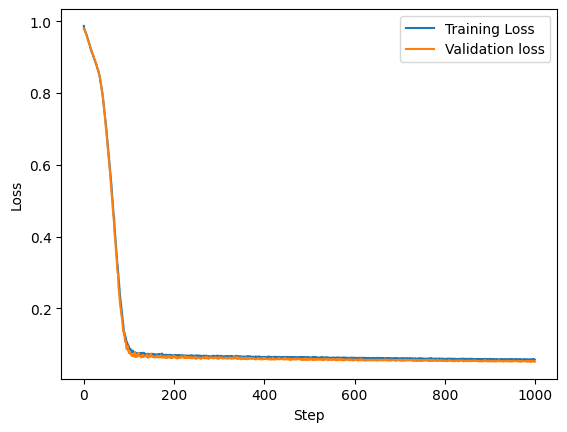

In [11]:
for col in history.columns:
    if col != "Step" and "Kullback-Leibler" not in col and "reconstruction" not in col:
        ax = sns.lineplot(data=history, x="Step", y=col, label=col)
plt.ylabel("Loss")
plt.legend()
plt.show()

## Plot results

### Reconstructed data

In [ ]:
# reconstructed_data = pd.read_csv("/mnt/d/runs/VAE/training/vae_tensorflow_cpu_hm_1/vae_tensorflow_cpu_hm_1.prediction.tsv", index_col="Unnamed: 0")#, sep="\t")

In [99]:
scale = 0.03
plot_df = pd.DataFrame(reconstructed_data.loc[0].values * scale , index=X.columns, columns=["inty"]).reset_index()    # Adjustment by scale
plot_df_2 = pd.DataFrame(X.iloc[0].values, index=X.columns, columns=["inty"]).reset_index()

In [100]:
mae = np.mean( np.abs((plot_df_2["inty"] - plot_df["inty"])) )
ae = np.sum( np.abs((plot_df_2["inty"] - plot_df["inty"])) )

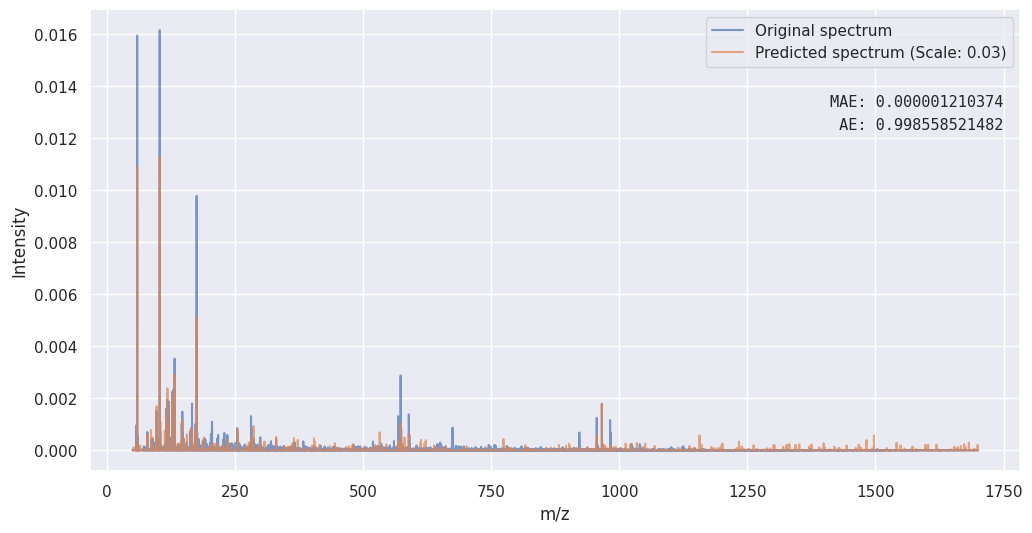

In [103]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7, label="Original spectrum")
predicted_label = "Predicted spectrum" if scale == 1.0 else f"Predicted spectrum (Scale: {scale})"
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7, label=predicted_label)
plt.ylabel("Intensity")
plt.xlabel("m/z")
plt.annotate(f"MAE: {format(mae, '.12f')}", xy=(0.795, 0.79), xycoords='axes fraction', fontsize=11, fontfamily="Monospace")
plt.annotate(f" AE: {format(ae, '.12f')}", xy=(0.795, 0.74), xycoords='axes fraction', fontsize=11, fontfamily="Monospace")
plt.legend()
plt.show()

(-0.0001, 0.003)

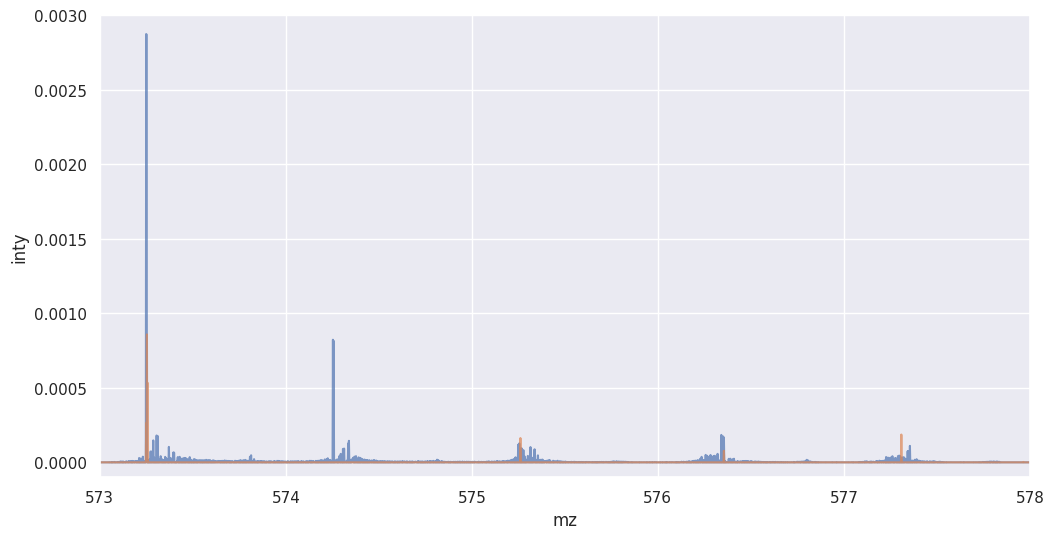

In [44]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573, 578)
ax.set_ylim(-0.0001, 0.003)

(-0.0001, 0.0022)

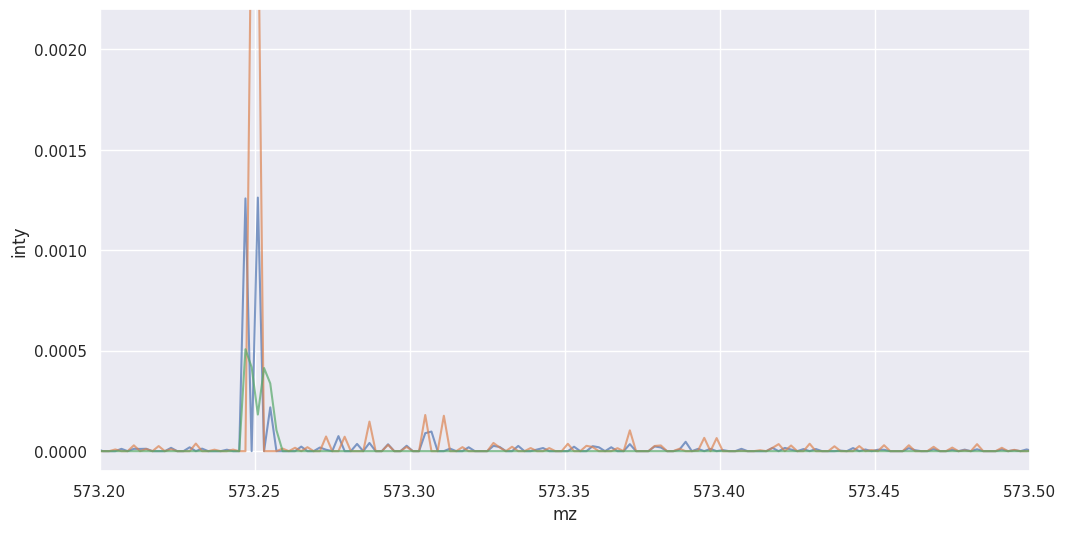

In [ ]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573.2, 573.5)
ax.set_ylim(-0.0001, 0.0022)

### Latent space

In [12]:
vae_enc

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
1,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
2,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
3,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
4,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
64,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
65,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001
66,-0.000023,0.000017,-0.000026,-0.000047,-0.000037,0.000003,-0.000021,-0.000047,-0.000011,-0.00002,...,-0.00005,0.000008,0.000068,0.000001,-0.00001,0.000007,-0.000095,0.000081,-0.00006,-0.000001


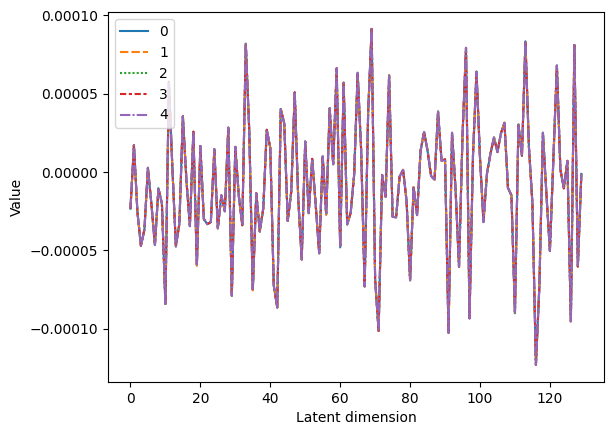

In [20]:
ax = sns.lineplot(data=vae_enc[:5].T)
plt.xlabel("Latent dimension")
plt.ylabel("Value")
plt.show()